In [72]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import os
from astropy.io import fits
import scipy.interpolate
from scipy.interpolate import splev, splrep
from scipy import interpolate
import scipy.interpolate as spi
import matplotlib
matplotlib.rcParams['axes.linewidth'] = 2

In [73]:
def new_degrade_R(input_wl, input_fl, wl_range, Res):
    ''' using established routine from the python module “coronagraph”
    '''
    import coronagraph as cg
    lowres_wl, lowres_dwl = cg.noise_routines.construct_lam(wl_range[0], wl_range[1], Res=Res)
    lowres_fl = cg.downbin_spec(input_fl, input_wl, lowres_wl, dlam=lowres_dwl)
    return lowres_wl, lowres_fl

In [74]:
Model_folder = '/Users/bosse/Pictures/Primary Grid Models/'
Data_folder = '/Users/bosse/Pictures/Observed Spectra files/'

In [75]:
df = pd.read_csv('/Users/bosse/Downloads/List of comparison graphs for poster - Sheet1 (4).csv')

In [76]:
name_object = df['name_benhmark'].values
f_sed = np.array([float(element) for element in df['F_sed'].values])
type_object = df['type_flag'].values
teff = df['Effective Temperature'].values
logg = df['Surface Gravity'].values
spt = df['Spectral Type'].values
companion_object = df['sep_companion'].values

In [77]:
df2 = pd.read_csv('/Users/bosse/Downloads/benchmark_taurus2022 (1).csv')

In [78]:
name_object2 = df2['name_benchmark'].values
spectra_object = df2['spectra_filename'].values

In [79]:
id_type_M = np.where(type_object == 0)
id_type_L = np.where(type_object == 1)
id_type_late_L = np.where(type_object == 2)
id_type_T = np.where(type_object == 3)

In [80]:
C_k_array = np.load('/Users/bosse/Pictures/C_k and G_k values/All C_k and G_k Values/all_Ck.npy')
grid_param = np.load('/Users/bosse/Pictures/C_k and G_k values/All C_k and G_k Values/all_grid_param.npy')
G_k_array = np.load('/Users/bosse/Pictures/C_k and G_k values/All C_k and G_k Values/all_Gk.npy')

In [81]:
logg_dict = {4:"100",
            4.5:"300",
            5:"1000",
            5.5:"3000"}
f_sed_dict = {1:"f1",
             2:"f2",
             3:"f3",
             4:"f4",
             10:"nc"}

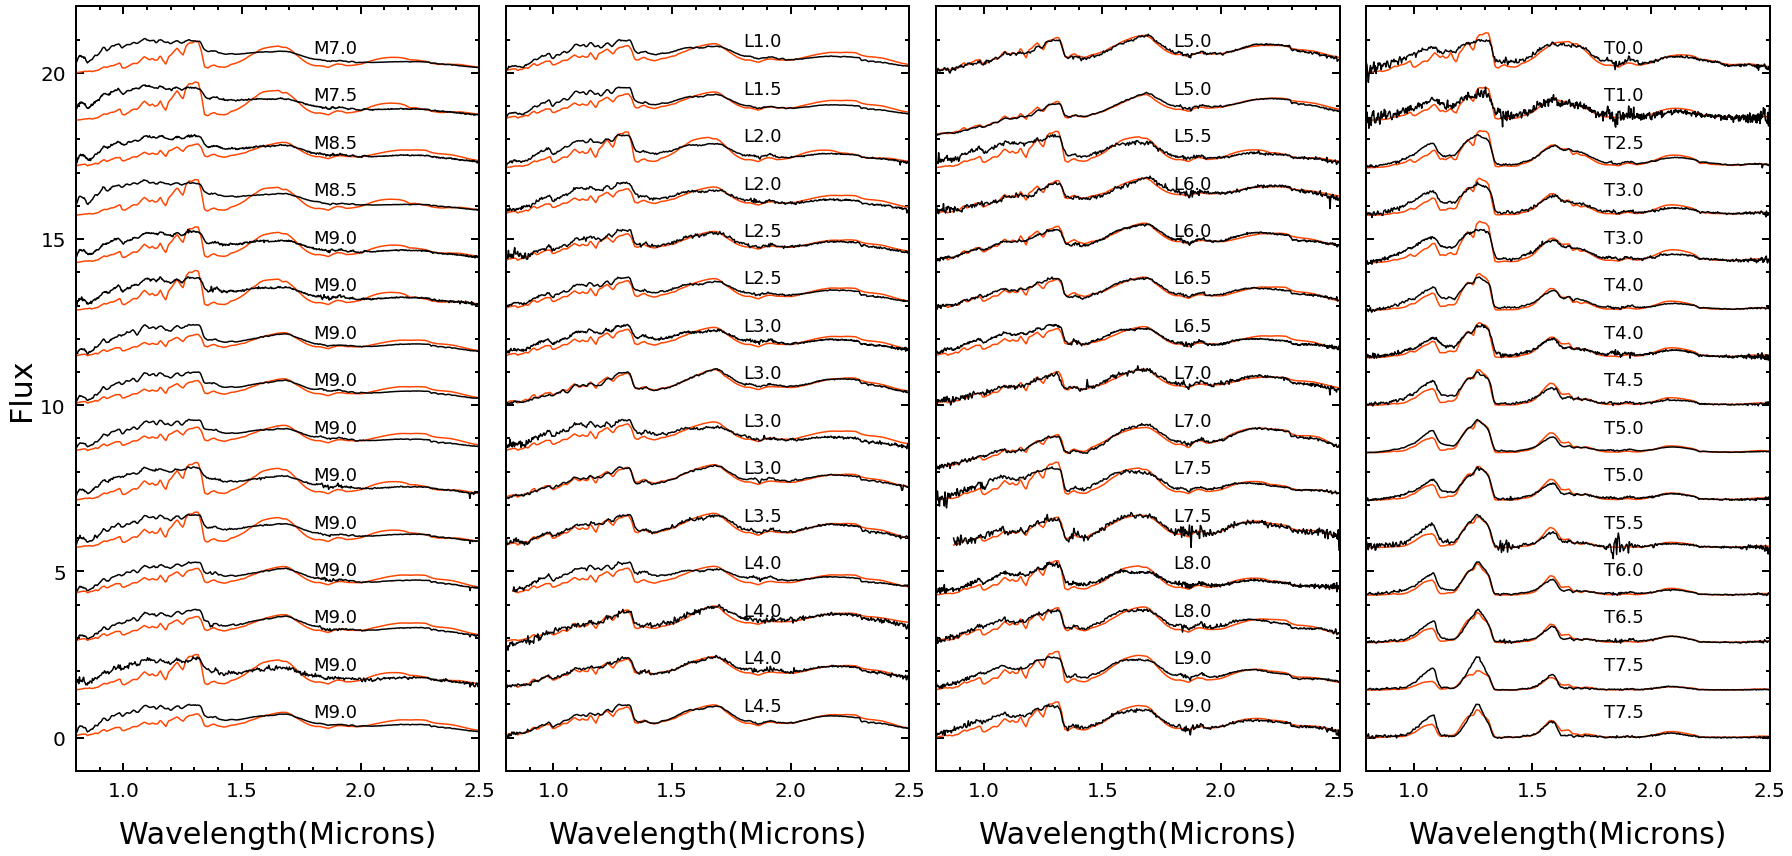

In [93]:
figure, axis = plt.subplots(1,4, figsize=(25,12))
offset_array = np.linspace(0,20,15)[::-1]
for index in range(15):
    current_object = name_object[id_type_M][index]
    current_sep = companion_object[id_type_M][index]
    current_teff = teff[id_type_M][index]
    current_logg = logg[id_type_M][index]
    current_spt = spt[id_type_M][index]
    current_f_sed = f_sed[id_type_M][index]
    current_type_object = type_object[id_type_M][index]
    
    id_object = np.where(name_object2 == current_object)[0][0]
    current_spectra = spectra_object[id_object]
    
    txt_flag = True
    if current_spectra[-4:] == "fits":
        txt_flag = False
    current_fullspectra_path = Data_folder + current_spectra
    if txt_flag: 
        data = np.loadtxt(current_fullspectra_path)
        w_data = data[:,0]
        f_data = data[:,1]
        u_data = data[:,2]
    else: 
        data = fits.open(current_fullspectra_path)[0].data
        w_data = data[0]
        f_data = data[1]
        u_data = data[2]
    id_good = np.where((np.isnan(f_data) == False) & (u_data != 0) & (w_data > 0.8) & (w_data < 2.5))
    w_data = w_data[id_good]
    f_data = f_data[id_good]
    u_data = u_data[id_good]
    id_j_band = np.where((w_data > 1.2) & (w_data < 1.35))
    f_max = np.max(f_data[id_j_band])
    f_data = f_data/f_max
    u_data = u_data/f_max
    
    
    Model_folder = '/Users/bosse/Pictures/Primary Grid Models/'
    C_k_1D_array = C_k_array[id_object]
    G_k_1D_array = G_k_array[id_object]
    IDbest = np.argmin(G_k_1D_array)
    current_teff, current_logg, current_f_sed = grid_param[IDbest]
    C_k_best = C_k_1D_array[IDbest]
    
    model_array_best = np.genfromtxt(Model_folder + "sp_t%dg%s%s"%(current_teff, logg_dict[current_logg], f_sed_dict[current_f_sed]), skip_header = 2)
    w_model_best = model_array_best[:,0]
    f_model_best = model_array_best[:,1]
    (new_w_model_best, new_f_model_best) = new_degrade_R(input_wl = w_model_best, input_fl = f_model_best, wl_range = [0.8,2.5], Res = 100)
    intfunc = spi.interp1d(new_w_model_best, new_f_model_best, fill_value="extrapolate")
    f_model_interp = intfunc(w_data)*C_k_best
    f_model_interp = f_model_interp/f_max
    
    
    axis[0].plot(w_data, f_model_interp + offset_array[index], linestyle = "-", color='orangered')
    axis[0].plot(w_data, f_data + offset_array[index], linestyle = "-", color='k')
    axis[0].text(1.8, offset_array[index] + 0.6, "M%.1f"%(current_spt), fontsize = 18)
    axis[0].set_xlim(0.8, 2.5)
    axis[0].set_ylim([-1,22])
    #axis.set_xticks([2003.5, 2004, 2004.5, 2005, 2005.5])
    #axis.set_xticklabels([‘2003.5’, ‘2004’, ‘2004.5’, ‘2005’, ‘2005.5’])
    axis[0].set_xlabel('Wavelength(Microns)', fontsize=30, labelpad=20)
    axis[0].set_ylabel("Flux", fontsize=30)
    axis[0].tick_params(which='both', direction='in', width=2, labelsize=20, pad=10)
    axis[0].tick_params(which='major', bottom=True, left=True, top=True, right=True, length=8)
    axis[0].tick_params(which='minor', bottom=True, left=True, top=True, right=True, length=4)
    axis[0].minorticks_on()
    
    
    
    
    
    
    
    
    
    
    
for index in range(15):
    current_object = name_object[id_type_L][index]
    current_sep = companion_object[id_type_L][index]
    current_teff = teff[id_type_L][index]
    current_logg = logg[id_type_L][index]
    current_spt = spt[id_type_L][index]
    current_f_sed = f_sed[id_type_L][index]
    current_type_object = type_object[id_type_L][index]
    
    id_object = np.where(name_object2 == current_object)[0][0]
    current_spectra = spectra_object[id_object]
    
    txt_flag = True
    if current_spectra[-4:] == "fits":
        txt_flag = False
    current_fullspectra_path = Data_folder + current_spectra
    if txt_flag: 
        data = np.loadtxt(current_fullspectra_path)
        w_data = data[:,0]
        f_data = data[:,1]
        u_data = data[:,2]
    else: 
        data = fits.open(current_fullspectra_path)[0].data
        w_data = data[0]
        f_data = data[1]
        u_data = data[2]
    id_good = np.where((np.isnan(f_data) == False) & (u_data != 0) & (w_data > 0.8) & (w_data < 2.5))
    w_data = w_data[id_good]
    f_data = f_data[id_good]
    u_data = u_data[id_good]
    id_j_band = np.where((w_data > 1.2) & (w_data < 1.35))
    f_max = np.max(f_data[id_j_band])
    f_data = f_data/f_max
    u_data = u_data/f_max
    
    
    Model_folder = '/Users/bosse/Pictures/Primary Grid Models/'
    C_k_1D_array = C_k_array[id_object]
    G_k_1D_array = G_k_array[id_object]
    IDbest = np.argmin(G_k_1D_array)
    current_teff, current_logg, current_f_sed = grid_param[IDbest]
    C_k_best = C_k_1D_array[IDbest]
    
    model_array_best = np.genfromtxt(Model_folder + "sp_t%dg%s%s"%(current_teff, logg_dict[current_logg], f_sed_dict[current_f_sed]), skip_header = 2)
    w_model_best = model_array_best[:,0]
    f_model_best = model_array_best[:,1]
    (new_w_model_best, new_f_model_best) = new_degrade_R(input_wl = w_model_best, input_fl = f_model_best, wl_range = [0.8,2.5], Res = 100)
    intfunc = spi.interp1d(new_w_model_best, new_f_model_best, fill_value="extrapolate")
    f_model_interp = intfunc(w_data)*C_k_best
    f_model_interp = f_model_interp/f_max
    
    
    axis[1].plot(w_data, f_model_interp + offset_array[index], linestyle = "-", color='orangered')
    axis[1].plot(w_data, f_data + offset_array[index], linestyle = "-", color='k')
    axis[1].text(1.8, offset_array[index] + 0.8, "L%.1f"%(current_spt - 10), fontsize = 18)
    axis[1].set_xlim(0.8, 2.5)
    axis[1].set_ylim([-1,22])
    axis[1].set_xlabel('Wavelength(Microns)', fontsize=30, labelpad=20)
    #axis.set_yticks([2003.5, 2004, 2004.5, 2005, 2005.5])
    axis[1].set_yticklabels([])
    axis[1].set_ylabel("", fontsize=30)
    axis[1].tick_params(which='both', direction='in', width=2, labelsize=20, pad=10)
    axis[1].tick_params(which='major', bottom=True, left=True, top=True, right=True, length=8)
    axis[1].tick_params(which='minor', bottom=True, left=True, top=True, right=True, length=4)
    axis[1].minorticks_on()

    
    
for index in range(15):
    current_object = name_object[id_type_late_L][index]
    current_sep = companion_object[id_type_late_L][index]
    current_teff = teff[id_type_late_L][index]
    current_logg = logg[id_type_late_L][index]
    current_spt = spt[id_type_late_L][index]
    current_f_sed = f_sed[id_type_late_L][index]
    current_type_object = type_object[id_type_late_L][index]
    
    id_object = np.where(name_object2 == current_object)[0][0]
    current_spectra = spectra_object[id_object]
    
    txt_flag = True
    if current_spectra[-4:] == "fits":
        txt_flag = False
    current_fullspectra_path = Data_folder + current_spectra
    if txt_flag: 
        data = np.loadtxt(current_fullspectra_path)
        w_data = data[:,0]
        f_data = data[:,1]
        u_data = data[:,2]
    else: 
        data = fits.open(current_fullspectra_path)[0].data
        w_data = data[0]
        f_data = data[1]
        u_data = data[2]
    id_good = np.where((np.isnan(f_data) == False) & (u_data != 0) & (w_data > 0.8) & (w_data < 2.5))
    w_data = w_data[id_good]
    f_data = f_data[id_good]
    u_data = u_data[id_good]
    id_j_band = np.where((w_data > 1.2) & (w_data < 1.35))
    f_max = np.max(f_data[id_j_band])
    f_data = f_data/f_max
    u_data = u_data/f_max
    
    
    Model_folder = '/Users/bosse/Pictures/Primary Grid Models/'
    C_k_1D_array = C_k_array[id_object]
    G_k_1D_array = G_k_array[id_object]
    IDbest = np.argmin(G_k_1D_array)
    current_teff, current_logg, current_f_sed = grid_param[IDbest]
    C_k_best = C_k_1D_array[IDbest]
    
    model_array_best = np.genfromtxt(Model_folder + "sp_t%dg%s%s"%(current_teff, logg_dict[current_logg], f_sed_dict[current_f_sed]), skip_header = 2)
    w_model_best = model_array_best[:,0]
    f_model_best = model_array_best[:,1]
    (new_w_model_best, new_f_model_best) = new_degrade_R(input_wl = w_model_best, input_fl = f_model_best, wl_range = [0.8,2.5], Res = 100)
    intfunc = spi.interp1d(new_w_model_best, new_f_model_best, fill_value="extrapolate")
    f_model_interp = intfunc(w_data)*C_k_best
    f_model_interp = f_model_interp/f_max
    
    if (index == 1) or (index == 8):
        offset_value = offset_array[index] - 0.5
    else: 
        offset_value = offset_array[index]
    axis[2].plot(w_data, f_model_interp + offset_value, linestyle = "-", color='orangered')
    axis[2].plot(w_data, f_data + offset_value, linestyle = "-", color='k')
    axis[2].text(1.8, offset_array[index] + 0.8, "L%.1f"%(current_spt - 10), fontsize = 18)
    axis[2].set_xlim(0.8, 2.5)
    axis[2].set_ylim([-1,22])
    axis[2].set_xlabel('Wavelength(Microns)', fontsize=30, labelpad=20)
    #axis.set_yticks([2003.5, 2004, 2004.5, 2005, 2005.5])
    axis[2].set_yticklabels([])
    axis[2].set_ylabel("", fontsize=30)
    axis[2].tick_params(which='both', direction='in', width=2, labelsize=20, pad=10)
    axis[2].tick_params(which='major', bottom=True, left=True, top=True, right=True, length=8)
    axis[2].tick_params(which='minor', bottom=True, left=True, top=True, right=True, length=4)
    axis[2].minorticks_on()    
    
    
    
    
for index in range(15):
    current_object = name_object[id_type_T][index]
    current_sep = companion_object[id_type_T][index]
    current_teff = teff[id_type_T][index]
    current_logg = logg[id_type_T][index]
    current_spt = spt[id_type_T][index]
    current_f_sed = f_sed[id_type_T][index]
    current_type_object = type_object[id_type_T][index]
    
    id_object = np.where(name_object2 == current_object)[0][0]
    current_spectra = spectra_object[id_object]
    
    txt_flag = True
    if current_spectra[-4:] == "fits":
        txt_flag = False
    current_fullspectra_path = Data_folder + current_spectra
    if txt_flag: 
        data = np.loadtxt(current_fullspectra_path)
        w_data = data[:,0]
        f_data = data[:,1]
        u_data = data[:,2]
    else: 
        data = fits.open(current_fullspectra_path)[0].data
        w_data = data[0]
        f_data = data[1]
        u_data = data[2]
    id_good = np.where((np.isnan(f_data) == False) & (u_data != 0) & (w_data > 0.8) & (w_data < 2.5))
    w_data = w_data[id_good]
    f_data = f_data[id_good]
    u_data = u_data[id_good]
    id_j_band = np.where((w_data > 1.2) & (w_data < 1.35))
    f_max = np.max(f_data[id_j_band])
    f_data = f_data/f_max
    u_data = u_data/f_max
    
    
    Model_folder = '/Users/bosse/Pictures/Primary Grid Models/'
    C_k_1D_array = C_k_array[id_object]
    G_k_1D_array = G_k_array[id_object]
    IDbest = np.argmin(G_k_1D_array)
    current_teff, current_logg, current_f_sed = grid_param[IDbest]
    C_k_best = C_k_1D_array[IDbest]
    
    model_array_best = np.genfromtxt(Model_folder + "sp_t%dg%s%s"%(current_teff, logg_dict[current_logg], f_sed_dict[current_f_sed]), skip_header = 2)
    w_model_best = model_array_best[:,0]
    f_model_best = model_array_best[:,1]
    (new_w_model_best, new_f_model_best) = new_degrade_R(input_wl = w_model_best, input_fl = f_model_best, wl_range = [0.8,2.5], Res = 100)
    intfunc = spi.interp1d(new_w_model_best, new_f_model_best, fill_value="extrapolate")
    f_model_interp = intfunc(w_data)*C_k_best
    f_model_interp = f_model_interp/f_max
    
    
    axis[3].plot(w_data, f_model_interp + offset_array[index], linestyle = "-", color='orangered')
    axis[3].plot(w_data, f_data + offset_array[index], linestyle = "-", color='k')
    axis[3].text(1.8, offset_array[index] + 0.6, "T%.1f"%(current_spt - 20), fontsize = 18)
    axis[3].set_xlim(0.8, 2.5)
    axis[3].set_ylim([-1,22])
    axis[3].set_yticklabels([])
    axis[3].set_xlabel('Wavelength(Microns)', fontsize=30, labelpad=20)
    axis[3].set_ylabel("", fontsize=30)
    axis[3].tick_params(which='both', direction='in', width=2, labelsize=20, pad=10)
    axis[3].tick_params(which='major', bottom=True, left=True, top=True, right=True, length=8)
    axis[3].tick_params(which='minor', bottom=True, left=True, top=True, right=True, length=4)
    axis[3].minorticks_on()
figure.set_tight_layout(True)
figure.savefig('/Users/bosse/Downloads/Brown Dwarf Figures.png', format = 'png', dpi = 1000, transparent=False)